In [1]:
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from tslearn.datasets import UCR_UEA_datasets
import os 

In [2]:
dataset='BasicMotions'

In [3]:
X_train,y_train, X_test, y_test=UCR_UEA_datasets().load_dataset(dataset)
train_x=X_train.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2])
train_y = y_train
test_y=y_test



In [4]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(train_y.reshape(-1,1))
pickle.dump(enc1,open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))



In [5]:
n_pred_classes =train_y.shape[1]
print('n pred classes',n_pred_classes) 
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)


n pred classes 4


In [6]:
model = ResNetBaseline(in_channels= X_train.shape[-1], num_pred_classes=n_pred_classes)
fit(model,train_loader,test_loader)
if dataset in os.listdir('../../ClassificationModels/models/'):
    print('Folder exists')
else: 
    os.mkdir(f'../../ClassificationModels/models/{dataset}')
torch.save(model.state_dict(), f'../../ClassificationModels/models/{dataset}/ResNet')

test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)
#test_preds=np.argmax(test_preds,axis=1)
sns.set(rc={'figure.figsize':(5,4)})
heatmap=confusion_matrix(ground_truth, test_preds)
sns.heatmap(heatmap, annot=True)
plt.savefig(f'../../ClassificationModels/models/{dataset}/ResNet_confusion_matrix.png')
plt.close()
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'../../ClassificationModels/models/{dataset}/classification_report.csv', index = False)



Epoch: 1, Train loss: 1.181, Val loss: 1.231
Epoch: 2, Train loss: 1.125, Val loss: 1.09
Epoch: 3, Train loss: 1.074, Val loss: 0.96
Epoch: 4, Train loss: 0.925, Val loss: 0.845
Epoch: 5, Train loss: 0.75, Val loss: 0.693
Epoch: 6, Train loss: 0.595, Val loss: 0.504
Epoch: 7, Train loss: 0.405, Val loss: 0.317
Epoch: 8, Train loss: 0.216, Val loss: 0.203
Epoch: 9, Train loss: 0.124, Val loss: 0.119
Epoch: 10, Train loss: 0.091, Val loss: 0.141
Epoch: 11, Train loss: 0.029, Val loss: 0.069
Epoch: 12, Train loss: 0.018, Val loss: 0.652
Epoch: 13, Train loss: 0.004, Val loss: 0.696
Epoch: 14, Train loss: 0.01, Val loss: 0.679
Epoch: 15, Train loss: 0.006, Val loss: 0.635
Epoch: 16, Train loss: 0.003, Val loss: 0.679
Epoch: 17, Train loss: 0.008, Val loss: 0.853
Epoch: 18, Train loss: 0.001, Val loss: 1.054
Epoch: 19, Train loss: 0.012, Val loss: 0.437
Epoch: 20, Train loss: 0.006, Val loss: 0.34
Epoch: 21, Train loss: 0.005, Val loss: 0.299
Epoch: 22, Train loss: 0.0, Val loss: 0.494
Epoc

# Explanation Algo

In [7]:
item=test_x[1].reshape(1,test_x.shape[1],-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
y_pred = torch.nn.functional.softmax(model(_item)).detach().numpy()
y_label= np.argmax(y_pred)


/home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [8]:
print(y_label)

2


In [9]:
from TSInterpret.InterpretabilityModels.counterfactual.Ates import AtesCF
exp_model= AtesCF(model,(train_x,train_y),backend='PYT',mode='feat', method= 'opt')


2022-07-06 09:34:09.467452: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 09:34:09.467470: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
exp = exp_model.explain(item)


Current may 2
3
Other ()
Best (1, 6, 100)


In [11]:
array, label=exp
print(label)

[3]


# Plot Item 

In [12]:
res = (item != array).any(-1)
ind=np.where(res[0])
print(res)

[[False  True  True False  True False]]


In [13]:
len(ind[0])

3

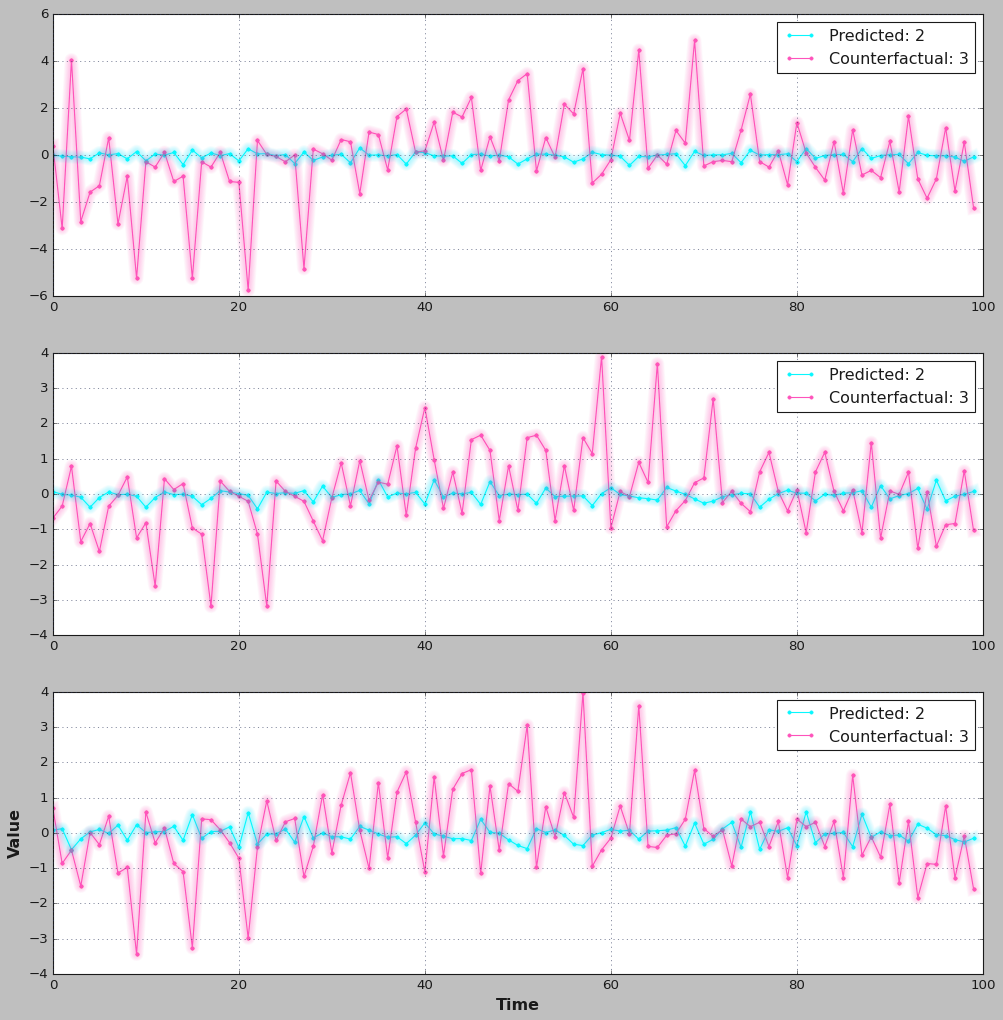

In [15]:
i=0
org_label=y_label
cf_label=label[0]
exp=array

exp_model.plot_in_one(item,org_label,exp,cf_label)